In [1]:
import pandas as pd
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterSampler

In [2]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def bLoss(outputs, labels, alpha = 1000):
    #specifying the batch size
    batch_size = outputs.size()[0]
    se = ((outputs[:,0,0] - labels[:,0,0])**2 \
           + (outputs[:,0,1] - labels[:,0,1])**2 \
           + (outputs[:,0,2] - labels[:,0,2])**2 \
           + (outputs[:,1,1] - labels[:,1,1])**2 \
           + (outputs[:,1,2] - labels[:,1,2])**2 \
           + (outputs[:,2,2] - labels[:,2,2])**2 \
          )/6
    eigs = torch.sort(torch.real(torch.linalg.eigvals(outputs)),descending=True)[0]
    zero = torch.zeros_like(outputs)
    zero_eig = torch.zeros_like(eigs[:,0])
    re = (torch.maximum(torch.maximum(outputs[:,0,0]-2/3, -(outputs[:,0,0] + 1/3)), zero[:,0,0])**2 \
        + torch.maximum(torch.maximum(outputs[:,1,1]-2/3, -(outputs[:,1,1] + 1/3)), zero[:,0,0])**2 \
        + torch.maximum(torch.maximum(outputs[:,2,2]-2/3, -(outputs[:,2,2] + 1/3)), zero[:,0,0])**2 \
        + torch.maximum(torch.maximum(outputs[:,0,1]-1/2, -(outputs[:,0,1] + 1/2)), zero[:,0,0])**2 \
        + torch.maximum(torch.maximum(outputs[:,0,2]-1/2, -(outputs[:,0,2] + 1/2)), zero[:,0,0])**2 \
        + torch.maximum(torch.maximum(outputs[:,1,2]-1/2, -(outputs[:,1,2] + 1/2)), zero[:,0,0])**2 \
          )/6 \
        + (torch.maximum((3*torch.abs(eigs[:,1])-eigs[:,1])/2 - eigs[:,0],zero_eig)**2) \
            + (torch.maximum(eigs[:,0] - (1/3 - eigs[:,0]),zero_eig)**2)
    return (se+alpha*re).mean()

def mseLoss(outputs, labels):
    #specifying the batch size
    batch_size = outputs.size()[0]
    se = ((outputs[:,0,0] - labels[:,0,0])**2 \
           + (outputs[:,0,1] - labels[:,0,1])**2 \
           + (outputs[:,0,2] - labels[:,0,2])**2 \
           + (outputs[:,1,1] - labels[:,1,1])**2 \
           + (outputs[:,1,2] - labels[:,1,2])**2 \
           + (outputs[:,2,2] - labels[:,2,2])**2 \
          )/6
    return (se).mean()

def realizLoss(outputs, labels, alpha = 1000):
    #specifying the batch size
    batch_size = outputs.size()[0]
    eigs = torch.sort(torch.real(torch.linalg.eigvals(outputs)),descending=True)[0]
    zero = torch.zeros_like(outputs)
    zero_eig = torch.zeros_like(eigs[:,0])
    re = (torch.maximum(torch.maximum(outputs[:,0,0]-2/3, -(outputs[:,0,0] + 1/3)), zero[:,0,0])**2 \
        + torch.maximum(torch.maximum(outputs[:,1,1]-2/3, -(outputs[:,1,1] + 1/3)), zero[:,0,0])**2 \
        + torch.maximum(torch.maximum(outputs[:,2,2]-2/3, -(outputs[:,2,2] + 1/3)), zero[:,0,0])**2 \
        + torch.maximum(torch.maximum(outputs[:,0,1]-1/2, -(outputs[:,0,1] + 1/2)), zero[:,0,0])**2 \
        + torch.maximum(torch.maximum(outputs[:,0,2]-1/2, -(outputs[:,0,2] + 1/2)), zero[:,0,0])**2 \
        + torch.maximum(torch.maximum(outputs[:,1,2]-1/2, -(outputs[:,1,2] + 1/2)), zero[:,0,0])**2 \
          )/6 \
        + (torch.maximum((3*torch.abs(eigs[:,1])-eigs[:,1])/2 - eigs[:,0],zero_eig)**2) \
            + (torch.maximum(eigs[:,0] - (1/3 - eigs[:,0]),zero_eig)**2)
    return (alpha*re).mean()

class TBNN(nn.Module):
    def __init__(self, N: int, input_dim: int, n_hidden: int, neurons: int, activation_function):
        super().__init__()
        self.N = N
        self.input_dim = input_dim   
        
        self.gn = nn.Linear(neurons,self.N)
        self.activation_function = activation_function
        self.hidden = nn.ModuleList()
        for k in range(n_hidden):
            self.hidden.append(nn.Linear(input_dim, neurons))
            input_dim = neurons  # For the next layer
                    
    def forward(self, x, Tn):
        for layer in self.hidden:
            x = self.activation_function(layer(x))
        gn = self.gn(x)
        b_pred = torch.sum(gn.view(-1,self.N,1,1)*torch.ones_like(Tn)*Tn,axis=1)
        return b_pred, gn
    
class bDataset(Dataset):
    def __init__(self, df, input_features, scaler=None):
        # convert into PyTorch tensors and remember them
        if scaler == None:
            self.X_scaler = StandardScaler()
            self.X_scaler.fit((df[input_features].values.astype(np.float32)))
        else: 
            self.X_scaler = scaler
        self.X = torch.from_numpy( self.X_scaler.transform(df[input_features].values.astype(np.float32))).to(device)
        self.y = torch.from_numpy( np.float32(self.assemble_b(df))).to(device)
        self.T = torch.from_numpy( np.float32(self.assemble_T(df))).to(device)
        
    def assemble_T(self,df):
        T = np.empty((self.__len__(),10,3,3))
        for i in range(10):
            T[:,i,0,0] = df[f'komegasst_T{i+1}_11']
            T[:,i,0,1] = df[f'komegasst_T{i+1}_12']
            T[:,i,0,2] = df[f'komegasst_T{i+1}_13']
            T[:,i,1,1] = df[f'komegasst_T{i+1}_22']
            T[:,i,1,2] = df[f'komegasst_T{i+1}_23']
            T[:,i,2,2] = df[f'komegasst_T{i+1}_22']
            
            T[:,i,1,0] = T[:,i,0,1]
            T[:,i,2,0] = T[:,i,0,2]
            T[:,i,2,1] = T[:,i,1,2]
        return T

    def assemble_b(self,df):
        b = np.empty((self.__len__(),3,3))
        b[:,0,0] = df['DNS_b_11']
        b[:,0,1] = df['DNS_b_12']
        b[:,0,2] = df['DNS_b_13']
        b[:,1,1] = df['DNS_b_22']
        b[:,1,2] = df['DNS_b_23']
        b[:,2,2] = df['DNS_b_33']
        b[:,1,0] = b[:,0,1]
        b[:,2,0] = b[:,0,2]
        b[:,2,1] = b[:,1,2]
        return b
        
    def __len__(self):
        # this should return the size of the dataset
        return len(self.X)
 
    def __getitem__(self, idx):
        # this should return one sample from the dataset
        features = self.X[idx]
        target = self.y[idx]
        Tn = self.T[idx]
        return features, Tn, target
    
def count_nonrealizable(b):
    eigs = torch.sort(torch.real(torch.linalg.eigvals(b)),descending=True)[0]
    zero = torch.zeros_like(b)
    zero_eig = torch.zeros_like(eigs[:,0])
    re = (torch.maximum(torch.maximum(b[:,0,0]-2/3, -(b[:,0,0] + 1/3)), zero[:,0,0])**2 \
        + torch.maximum(torch.maximum(b[:,1,1]-2/3, -(b[:,1,1] + 1/3)), zero[:,0,0])**2 \
        + torch.maximum(torch.maximum(b[:,2,2]-2/3, -(b[:,2,2] + 1/3)), zero[:,0,0])**2 \
        + torch.maximum(torch.maximum(b[:,0,1]-1/2, -(b[:,0,1] + 1/2)), zero[:,0,0])**2 \
        + torch.maximum(torch.maximum(b[:,0,2]-1/2, -(b[:,0,2] + 1/2)), zero[:,0,0])**2 \
        + torch.maximum(torch.maximum(b[:,1,2]-1/2, -(b[:,1,2] + 1/2)), zero[:,0,0])**2 \
          )/6 \
        + (torch.maximum((3*torch.abs(eigs[:,1])-eigs[:,1])/2 - eigs[:,0],zero_eig)**2) \
            + (torch.maximum(eigs[:,0] - (1/3 - eigs[:,0]),zero_eig)**2)
    n_nr = torch.count_nonzero(re)
    return n_nr

class Result(defaultdict):
    def __init__(self, value=None):
        super(results, self).__init__(results)
        self.value = value

In [46]:
#hyperparams
neurons = 30
n_hidden = 5
input_features = ['komegasst_q6','komegasst_q5','komegasst_I1_1','komegasst_I1_3','komegasst_I2_3','komegasst_I1_5']
early_stopping_patience = 20
max_epochs = 1000
learning_rate = 0.001
learning_rate_decay = 0.98
batch_size = 64
activation_function = nn.SiLU()
dataset = '/home/ryley/WDK/ML/dataset/komegasst_split.csv'
test_set = ['case_1p2','fp_3630']
final_val_set = ['case_1p0','fp_2000','fp_3970']
val_sets = {0: ['case_0p5','fp_2540','fp_1000'],
            1: ['case_0p8','fp_4060','fp_3270'],
            2: ['case_1p5','fp_1410','fp_3030']}
loss_fn = bLoss

params = {'neurons': neurons,
          'n_hidden': n_hidden,
          'input_features': input_features,
          'early_stopping_patience': early_stopping_patience,
          'max_epochs': max_epochs,
          'learning_rate': learning_rate,
          'learning_rate_decay': learning_rate_decay,
          'batch_size': batch_size,
          'activation_function': activation_function}

In [3]:
#pseudo code
#load csv
#split into test/val_final/training_validation df
#calculate Tn, b tensors
#for model in models:
#    for cross_validation set:
#        scale input features 
#        batched, early stopped training loop 
#        compute training/validation loss i
#    compute average validation loss
#    plot loss curves
#    early stopped training loop with val_final
#    model save

In [42]:
param_grid = {'neurons':[10,20,30,40,50,60,70,80],
              'layers': [2,3,4,5,6,7,8,9,10],
              'lr':[0.01,0.001,0.0001,0.00001],
              'lr_decay':[1, 0.999, 0.99, 0.98, 0.95, 0.9, 0.8],
              'batch_size':[64,128,256,512,1024]}
param_list = list(ParameterSampler(param_grid, n_iter=100,
                                   random_state=7))

In [11]:
def early_stopped_tbnn_training_run(model_params, training_params, df_tv):
    loss_fn = bLoss
    loss_values = []
    val_loss_values = []
    df_valid = df_tv[df_tv['Case'].isin(training_params['val_set'])]
    df_train = df_tv[~df_tv['Case'].isin(training_params['val_set'])]
    tDs = bDataset(df_train, input_features=model_params['input_features'])
    vDs = bDataset(df_valid, input_features=model_params['input_features'], scaler = tDs.X_scaler)
    loader = DataLoader(tDs, shuffle=True, batch_size=training_params['batch_size'])

    print(f'Training points: {len(df_train)}, validation points {len(df_valid)}')

    model = TBNN(N = 10,
                 input_dim = len(model_params['input_features']),
                 n_hidden = model_params['n_hidden'],
                 neurons = model_params['neurons'],
                 activation_function = model_params['activation_function']
                ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=training_params['learning_rate'])
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=training_params['learning_rate_decay'])
    early_stopper = EarlyStopper(patience=training_params['early_stopping_patience'], min_delta=0)

    print('EPOCH    LR        TRAIN     VALID         MSE:T/V              RL:T/V         %NR_t/%NR_v')
    print('=============================================================================================')
    for epoch in range(1, training_params['max_epochs']+1):
        model.train()
        for X_batch, T_batch, y_batch in loader:
            y_pred, g_pred = model(X_batch, T_batch)
            optimizer.zero_grad()
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            for X, T, y in DataLoader(tDs, shuffle=False, batch_size=tDs.__len__()):
                y_pred_train, g_pred = model(X, T)
                loss_values.append(loss_fn(y_pred_train,y).item())
                mse_t = mseLoss(y_pred_train,y).item()  
                rl_t = realizLoss(y_pred_train,y).item()  
            for X, T, y in DataLoader(vDs, shuffle=False, batch_size=vDs.__len__()):
                y_pred_val, g_pred = model(X, T)
                val_loss_values.append(loss_fn(y_pred_val,y).item())   
                mse_v = mseLoss(y_pred_val,y).item()  
                rl_v = realizLoss(y_pred_val,y).item() 

        if early_stopper.early_stop(val_loss_values[-1]):
            print(f"{epoch:3d}   "
                  f"{lr_scheduler._last_lr[-1]:.3e}   "
                  f"{loss_values[-1]:.5f}   "
                  f"{val_loss_values[-1]:.5f}   "
                  f"{mse_t:.5f} / {mse_v:.5f}   "
                  f"{rl_t:.5f} / {rl_v:.5f}   "
                  f"{count_nonrealizable(y_pred_train)/len(y_pred_train)*100:.2f}% / {count_nonrealizable(y_pred_val)/len(y_pred_val)*100:.2f}%")
            break   

        if (epoch % 10==0 or epoch==1):
            print(f"{epoch:3d}   "
                  f"{lr_scheduler._last_lr[-1]:.3e}   "
                  f"{loss_values[-1]:.5f}   "
                  f"{val_loss_values[-1]:.5f}   "
                  f"{mse_t:.5f} / {mse_v:.5f}   "
                  f"{rl_t:.5f} / {rl_v:.5f}   "
                  f"{count_nonrealizable(y_pred_train)/len(y_pred_train)*100:.2f}% / {count_nonrealizable(y_pred_val)/len(y_pred_val)*100:.2f}%")

        lr_scheduler.step()
    return model, loss_values, val_loss_values

In [12]:
dataset = '/home/ryley/WDK/ML/dataset/komegasst_split.csv'
test_set = ['case_1p2','fp_3630']
final_val_set = ['case_1p0','fp_2000','fp_3970']
val_sets = {0: ['case_0p5','fp_2540','fp_1000'],
            1: ['case_0p8','fp_4060','fp_3270'],
            2: ['case_1p5','fp_1410','fp_3030']}

df = pd.read_csv(dataset)
df_test = df[df['Case'].isin(test_set)]
df_final_val = df[df['Case'].isin(final_val_set)]
df_tv = df[~df['Case'].isin(test_set+final_val_set)]
print(f'Dataset: {len(df)}, test: {len(df_test)}, final_val: {len(df_final_val)}, tv: {len(df_tv)}')
training_params = {'early_stopping_patience': 20,
                'max_epochs': 1000,
                'learning_rate': 0.001,
                'learning_rate_decay': 0.98,
                'batch_size': 128,
                'val_set':['case_1p5','fp_1410','fp_3030'],
               }

model_params = {'neurons': 50,
                'n_hidden': 5,
                'activation_function': nn.SiLU(),
                'input_features': ['komegasst_q6','komegasst_q5','komegasst_I1_1','komegasst_I1_3','komegasst_I2_3','komegasst_I1_5']
}
results = early_stopped_tbnn_training_run(model_params,training_params,df_tv)

Dataset: 75152, test: 14919, final_val: 15069, tv: 45164
Training points: 30116, validation points 15048
EPOCH    LR        TRAIN     VALID         MSE:T/V              RL:T/V         %NR_t/%NR_v
  1   1.000e-03   0.01142   0.01114   0.01136 / 0.01113   0.00006 / 0.00001   1.53% / 2.48%
 10   8.337e-04   0.00705   0.00787   0.00704 / 0.00758   0.00000 / 0.00029   0.36% / 1.00%
 20   6.812e-04   0.00687   0.00748   0.00686 / 0.00747   0.00001 / 0.00002   4.06% / 5.26%
 30   5.566e-04   0.00668   0.00743   0.00666 / 0.00731   0.00002 / 0.00012   0.87% / 1.77%
 40   4.548e-04   0.00657   0.00724   0.00657 / 0.00718   0.00000 / 0.00007   3.10% / 3.69%
 50   3.716e-04   0.00651   0.00729   0.00650 / 0.00717   0.00001 / 0.00012   4.28% / 6.88%
 60   3.036e-04   0.00654   0.00731   0.00641 / 0.00712   0.00013 / 0.00019   10.04% / 9.71%


In [47]:
#%%time

df = pd.read_csv(dataset)
df_test = df[df['Case'].isin(test_set)]
df_final_val = df[df['Case'].isin(final_val_set)]
df_tv = df[~df['Case'].isin(test_set+final_val_set)]
print(f'Dataset: {len(df)}, test: {len(df_test)}, final_val: {len(df_final_val)}, tv: {len(df_tv)}')
n_clusters = df['Cluster'].nunique()
results = {c: {s: {t: [] for t in ['Train','Valid']} for s in val_sets.keys()} for c in range(n_clusters)}
#results = defaultdict(dict).fromkeys(range(n_clusters))

#tDs = bDataset(df,input_features=input_features)
#loss_values = dict.fromkeys(range(n_clusters))
#val_loss_values = dict.fromkeys(range(n_clusters))

print('Cluster value counts: ')
search_results = dict.fromkeys(range(len(param_list)))

#print('\n=======================================')
#print(f'SEARCH ITER: {search_iter}, params: {params}')
#print('=======================================\n')

#neurons = params['neurons']
#n_hidden = params['layers']
#learning_rate = params['lr']
for cluster in range(1):#range(n_clusters):
    print(f'Cluster: {cluster}')
    for set_i in val_sets.keys():
        loss_values = []
        val_loss_values = []
        df_valid = df_tv[((df_tv['Case'].isin(val_sets[set_i])) & (df_tv['Cluster']==cluster))]
        df_train = df_tv[((~df_tv['Case'].isin(val_sets[set_i])) & (df_tv['Cluster']==cluster))]

        tDs = bDataset(df_train, input_features=input_features)
        vDs = bDataset(df_valid, input_features=input_features, scaler = tDs.X_scaler)
        loader = DataLoader(tDs, shuffle=True, batch_size=batch_size)

        print(f'Training points: {len(df_train)}, validation points {len(df_valid)}')
              
        model = TBNN(N = 10,
                     input_dim = len(input_features),
                     n_hidden = n_hidden,
                     neurons = neurons,
                     activation_function=activation_function
                    ).to(device)
              
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=learning_rate_decay)
        early_stopper = EarlyStopper(patience=early_stopping_patience, min_delta=0)
              
        print('EPOCH    LR        TRAIN     VALID         MSE:T/V              RL:T/V         %NR_t/%NR_v')
        print('===========================================================================-==============')
        for epoch in range(1,max_epochs+1):
            model.train()
            for X_batch, T_batch, y_batch in loader:
                y_pred, g_pred = model(X_batch, T_batch)
                optimizer.zero_grad()
                loss = loss_fn(y_pred, y_batch)
                loss.backward()
                optimizer.step()
                
            model.eval()
            with torch.no_grad():
                for X, T, y in DataLoader(tDs, shuffle=False, batch_size=tDs.__len__()):
                    y_pred_train, g_pred = model(X, T)
                    loss_values.append(loss_fn(y_pred_train,y).item())
                    mse_t = mseLoss(y_pred_train,y).item()  
                    rl_t = realizLoss(y_pred_train,y).item()  
                for X, T, y in DataLoader(vDs, shuffle=False, batch_size=vDs.__len__()):
                    y_pred_val, g_pred = model(X, T)
                    val_loss_values.append(loss_fn(y_pred_val,y).item())   
                    mse_v = mseLoss(y_pred_val,y).item()  
                    rl_v = realizLoss(y_pred_val,y).item() 

            if early_stopper.early_stop(val_loss_values[-1]):
                print(f"{epoch:3d}   "
                      f"{lr_scheduler._last_lr[-1]:.3e}   "
                      f"{loss_values[-1]:.5f}   "
                      f"{val_loss_values[-1]:.5f}   "
                      f"{mse_t:.5f} / {mse_v:.5f}   "
                      f"{rl_t:.5f} / {rl_v:.5f}   "
                      f"{count_nonrealizable(y_pred_train)/len(y_pred_train)*100:.2f}% / {count_nonrealizable(y_pred_val)/len(y_pred_val)*100:.2f}%")
                break   

            if (epoch % 10==0 or epoch==1):
                print(f"{epoch:3d}   "
                      f"{lr_scheduler._last_lr[-1]:.3e}   "
                      f"{loss_values[-1]:.5f}   "
                      f"{val_loss_values[-1]:.5f}   "
                      f"{mse_t:.5f} / {mse_v:.5f}   "
                      f"{rl_t:.5f} / {rl_v:.5f}   "
                      f"{count_nonrealizable(y_pred_train)/len(y_pred_train)*100:.2f}% / {count_nonrealizable(y_pred_val)/len(y_pred_val)*100:.2f}%")
                
            lr_scheduler.step()
            
        results[cluster][set_i]['Train'] = loss_values
        results[cluster][set_i]['Valid'] = val_loss_values


Dataset: 75152, test: 14919, final_val: 15069, tv: 45164
Cluster value counts: 
Cluster: 0
Training points: 3799, validation points 1670
EPOCH    LR        TRAIN     VALID         MSE:T/V              RL:T/V         %NR_t/%NR_v
===========================================================================-==============
  1   1.000e-03   0.02580   0.02694   0.02561 / 0.02693   0.00019 / 0.00001   0.84% / 0.06%
 10   8.337e-04   0.01156   0.01222   0.01155 / 0.01222   0.00001 / 0.00000   2.55% / 0.60%
 20   6.812e-04   0.01143   0.01209   0.01142 / 0.01209   0.00001 / 0.00000   2.16% / 0.24%
 30   5.566e-04   0.01204   0.01275   0.01202 / 0.01275   0.00002 / 0.00001   8.98% / 4.25%
 40   4.548e-04   0.01139   0.01206   0.01138 / 0.01206   0.00001 / 0.00000   6.69% / 2.04%
 50   3.716e-04   0.01154   0.01223   0.01154 / 0.01223   0.00001 / 0.00000   7.71% / 2.28%
 60   3.036e-04   0.01132   0.01199   0.01132 / 0.01199   0.00000 / 0.00000   7.19% / 2.63%
 70   2.481e-04   0.01132   0.01200  

KeyboardInterrupt: 

In [ ]:
#%%time

df = pd.read_csv(dataset)
df_test = df[df['Case'].isin(test_set)]
df_final_val = df[df['Case'].isin(final_val_set)]
df_tv = df[~df['Case'].isin(test_set+final_val_set)]
print(f'Dataset: {len(df)}, test: {len(df_test)}, final_val: {len(df_final_val)}, tv: {len(df_tv)}')
n_clusters = df['Cluster'].nunique()
results = {c: {s: {t: [] for t in ['Train','Valid']} for s in val_sets.keys()} for c in range(n_clusters)}
#results = defaultdict(dict).fromkeys(range(n_clusters))

#tDs = bDataset(df,input_features=input_features)
#loss_values = dict.fromkeys(range(n_clusters))
#val_loss_values = dict.fromkeys(range(n_clusters))

print('Cluster value counts: ')
print(df_tv['Cluster'].value_counts())
search_results = dict.fromkeys(range(len(param_list)))

for search_iter,params in enumerate(param_list):
    print('\n=======================================')
    print(f'SEARCH ITER: {search_iter}, params: {params}')
    print('=======================================\n')

    neurons = params['neurons']
    n_hidden = params['layers']
    learning_rate = params['lr']
    for cluster in range(n_clusters):
        print(f'Cluster: {cluster}')
        for set_i in val_sets.keys():
            loss_values = []
            val_loss_values = []
            df_valid = df_tv[((df_tv['Case'].isin(val_sets[set_i])) & (df_tv['Cluster']==cluster))]
            df_train = df_tv[((~df_tv['Case'].isin(val_sets[set_i])) & (df_tv['Cluster']==cluster))]

            tDs = bDataset(df_train, input_features=input_features)
            vDs = bDataset(df_valid, input_features=input_features, scaler = tDs.X_scaler)
            print(len(df_train))
            loader = DataLoader(tDs, shuffle=True, batch_size=100)
            model = TBNN(N=10, input_dim=len(input_features), n_hidden = n_hidden, neurons = neurons, activation_function=activation_function).to(device)
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            early_stopper = EarlyStopper(patience=early_stopping_patience, min_delta=0)
            print('EPOCH  TRAIN     VALID         MSE:T/V              RL:T/V         %NR_t/%NR_v')
            print('===============================================================================')

            for epoch in range(1,max_epochs+1):
                model.train()
                for X_batch, T_batch, y_batch in loader:
                    y_pred, g_pred = model(X_batch, T_batch)
                    loss = loss_fn(y_pred, y_batch)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                model.eval()
                with torch.no_grad():
                    for X, T, y in DataLoader(tDs, shuffle=False, batch_size=tDs.__len__()):
                        y_pred_train, g_pred = model(X, T)
                        loss_values.append(loss_fn(y_pred_train,y).item())
                        mse_t = mseLoss(y_pred_train,y).item()  
                        rl_t = realizLoss(y_pred_train,y).item()  
                    for X, T, y in DataLoader(vDs, shuffle=False, batch_size=vDs.__len__()):
                        y_pred_val, g_pred = model(X, T)
                        val_loss_values.append(loss_fn(y_pred_val,y).item())   
                        mse_v = mseLoss(y_pred_val,y).item()  
                        rl_v = realizLoss(y_pred_val,y).item() 

                if early_stopper.early_stop(val_loss_values[-1]):
                    print(f"{epoch:3d}   "
                          f"{loss_values[-1]:.5f}   "
                          f"{val_loss_values[-1]:.5f}   "
                          f"{mse_t:.5f} / {mse_v:.5f}   "
                          f"{rl_t:.5f} / {rl_v:.5f}   "
                          f"{count_nonrealizable(y_pred_train)/len(y_pred_train)*100:.2f}% / {count_nonrealizable(y_pred_val)/len(y_pred_val)*100:.2f}%")

                    break   

                if (epoch % 10==0 or epoch==1):
                    print(f"{epoch:3d}   "
                          f"{loss_values[-1]:.5f}   "
                          f"{val_loss_values[-1]:.5f}   "
                          f"{mse_t:.5f} / {mse_v:.5f}   "
                          f"{rl_t:.5f} / {rl_v:.5f}   "
                          f"{count_nonrealizable(y_pred_train)/len(y_pred_train)*100:.2f}% / {count_nonrealizable(y_pred_val)/len(y_pred_val)*100:.2f}%")
            results[cluster][set_i]['Train'] = loss_values
            results[cluster][set_i]['Valid'] = val_loss_values
    search_results[search_iter] = results

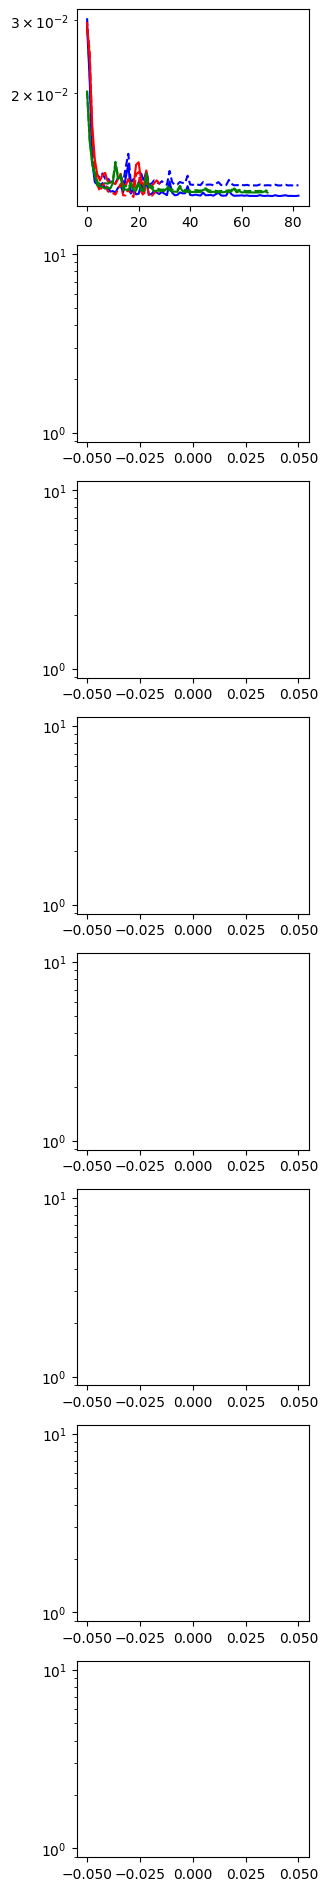

In [45]:
fig, axs = plt.subplots(n_clusters,figsize=(3,n_clusters*3))
for i, ax in enumerate(axs):
    colors = ['b','r','g']
    for set_i in val_sets.keys():
        ax.plot(results[i][set_i]['Train'],'-',color=colors[set_i])
        ax.plot(results[i][set_i]['Valid'],'--',color=colors[set_i])
    ax.semilogy()

In [ ]:
plt.plot(loss_values)
plt.plot(val_loss_values)